In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
CHANNELS = 3
EPOCHS = 50

In [3]:
#import data into tensorflow dataset object
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/q/Downloads/All Data/Data",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 24723 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Apple Cedar  rust',
 'Apple Scab',
 'Corn Gray leaf spot',
 'Corn Northern Leaf Blight',
 'Grape Black rot',
 'Grape Isariopsis Leaf Spot',
 'Potato Late blight',
 'Potato Phytopthora Infestans',
 'Tomato Early blight',
 'Tomato Late blight']

In [5]:
len(dataset)

6181

(256, 256, 3)


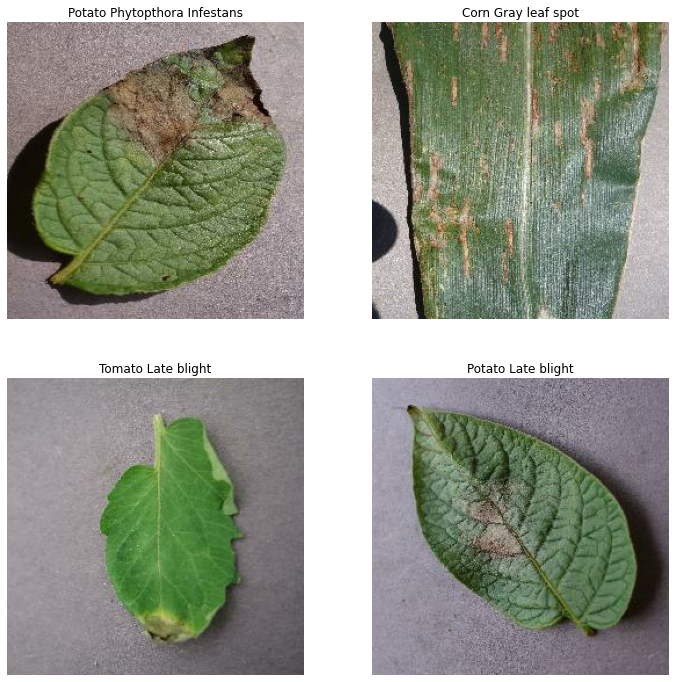

In [6]:
#let's now try to visualize our images with their label
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        
        
    print(image_batch[0].shape)

In [7]:
#Now let's split our dataset into train and test splits
len(dataset)

6181

In [8]:
train_size = 0.8
test_size = 0.1
val_size = 0.1

In [9]:
#now let's print the sizes of our dataset:
len(dataset)*train_size, len(dataset)*test_size, len(dataset)*val_size

(4944.8, 618.1, 618.1)

In [10]:
train_ds = dataset.take(932)
test_ds = dataset.skip(932)
val_ds = test_ds.take(116)

In [11]:
len(train_ds), len(test_ds), len(val_ds)

(932, 5249, 116)

In [12]:
test_ds = test_ds.skip(116)

In [13]:
len(test_ds)

5133

In [14]:
len(train_ds), len(test_ds), len(val_ds)

(932, 5133, 116)

In [15]:
#let's writre a function dto split our data automatically
def get_dataset_partitions_tf(ds,train_split = 0.8,test_split = 0.1,val_split = 0.1, shuffle =True, shuffle_size=100000 ):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 1200)
        
    train_size = int(train_split*ds_size)
    val_size = int(ds_size*val_split)
    
    train_data = ds.take(train_size)
    val_data = ds.skip(train_size).take(val_size)
    test_data = ds.skip(train_size).skip(val_size)
    return train_data, test_data, val_data 

In [16]:
train, test, val = get_dataset_partitions_tf(dataset)
len(train), len(test), len(val)

(4944, 619, 618)

In [17]:
#This is made to optimize the moderl performance so that tthe model trains better because of the pipeline stuff...
train = train.cache().shuffle(100000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(100000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(100000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
#Now let's scale our images AKA data normalization
#And also the resize layer will take care of resizing the images submitted the model during training even if they are not of size 256x256
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [19]:
#Here we will perform the data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
#Let's now begin with the model building
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15
model_1 = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters= 32, kernel_size = (3, 3,), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters= 64, kernel_size= (3, 3), activation = 'relu'),                       
    layers.MaxPooling2D((2,2)),                    
    layers.Conv2D(filters= 64, kernel_size= (3, 3), activation = 'relu'),                       
    layers.MaxPooling2D((2,2)),                    
    # layers.Conv2D(filters= 64, kernel_size= (3, 3), activation = 'relu'),                       
    # layers.MaxPooling2D((2,2)),                    
    layers.Conv2D(filters= 64, kernel_size= (3, 3), activation = 'relu'),                       
    layers.MaxPooling2D((2,2)),                    
    layers.Conv2D(filters= 64, kernel_size= (3, 3), activation = 'relu'),                       
    layers.MaxPooling2D((2,2)),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

In [21]:
#Model's building
model_1.build(input_shape=input_shape)

model_1.summary()

In [22]:
#let's now compile our model:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [23]:
#Now we will train our netwrork and we will record the history of every epochs:
history = model_1.fit(
    train,
    epochs= 8,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val
)


Epoch 1/8


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'